# Toma de decisiones de negocios basado en datos

## Importación de librerías

In [27]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

# Configuración visual
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

print("Librerías importadas correctamente.")


Librerías importadas correctamente.


## Carga y vista inicial de datos

In [28]:
# Paso 3 - Carga de datasets
hypo = pd.read_csv('/datasets/hypotheses_us.csv')
orders = pd.read_csv('/datasets/orders_us.csv', parse_dates=['date'])
visits = pd.read_csv('/datasets/visits_us.csv', parse_dates=['date'])

# Vista inicial
print("=== Hypotheses ===")
display(hypo.head())
print(hypo.info())

print("\n=== Orders ===")
display(orders.head())
print(orders.info())

print("\n=== Visits ===")
display(visits.head())
print(visits.info())

# Valores nulos por dataset
print("\nValores nulos en Hypotheses:\n", hypo.isna().sum())
print("\nValores nulos en Orders:\n", orders.isna().sum())
print("\nValores nulos en Visits:\n", visits.isna().sum())

=== Hypotheses ===


,Hypothesis;Reach;Impact;Confidence;Effort
0,Add two new channels for attracting traffic. This will bring 30% more users;3;10;8;6
1,Launch your own delivery service. This will shorten delivery time;2;5;4;10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size;8;3;7;3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly;8;3;3;8
4,Change the background color on the main page. This will increase user engagement;3;1;1;1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Hypothesis;Reach;Impact;Confidence;Effort  9 non-null      object
dtypes: object(1)
memory usage: 200.0+ bytes
None

=== Orders ===


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.40,B
1,2804400009,3642806036,2019-08-15,15.20,B
2,2961555356,4069496402,2019-08-15,10.20,A
3,3797467345,1196621759,2019-08-15,155.10,B
4,2282983706,2322279887,2019-08-15,40.50,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB
None

=== Visits ===


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None

Valores nulos en Hypotheses:
 Hypothesis;Reach;Impact;Confidence;Effort    0
dtype: int64

Valores nulos en Orders:
 transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Valores nulos en Visits:
 date      0
group     0
visits    0
dtype: int64


## Limpieza de datos

In [29]:
# Mostrar texto completo en columnas
pd.set_option('display.max_colwidth', None)

# 1) Leer con separador correcto
hypo = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')

# 2) Revisar estructura
print("Vista inicial:")
display(hypo.head())
print(hypo.info())

# 3) Renombrar columnas por consistencia
hypo.columns = hypo.columns.str.strip().str.capitalize()

# 4) Conversión de columnas numéricas
cols_num = ['Reach', 'Impact', 'Confidence', 'Effort']
hypo[cols_num] = hypo[cols_num].apply(pd.to_numeric, errors='coerce')

# 5) Revisar valores nulos
print("\nValores nulos por columna:")
print(hypo.isna().sum())

# 6) Validar rangos esperados: 1 a 10
for col in cols_num:
    fuera_rango = hypo[~hypo[col].between(1, 10)]
    if not fuera_rango.empty:
        print(f"\n⚠ Valores fuera de rango en {col}:")
        display(fuera_rango)

# 7) Eliminar duplicados
dup_count = hypo.duplicated().sum()
if dup_count > 0:
    print(f"\n⚠ Se eliminaron {dup_count} filas duplicadas.")
    hypo = hypo.drop_duplicates().reset_index(drop=True)

# 8) Vista final limpia
print("\nDataFrame limpio:")
display(hypo.head())
print(hypo.info())


Vista inicial:


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None

Valores nulos por columna:
Hypothesis    0
Reach         0
Impact        0
Confidence    0
Effort        0
dtype: int64

DataFrame limpio:


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None


La infomación ya está limpia para calcular y ordenar.

## ICE & RICE para priorizar las hipótesis

In [30]:
# Calcular ICE y RICE
hypo['ICE'] = (hypo['Impact'] * hypo['Confidence']) / hypo['Effort']
hypo['RICE'] = (hypo['Reach'] * hypo['Impact'] * hypo['Confidence']) / hypo['Effort']

# Ranking por RICE
print("Ranking por RICE")
display(hypo.sort_values(by='RICE', ascending=False).reset_index(drop=True))

# Ranking por ICE
print("Ranking por ICE")
display(hypo.sort_values(by='ICE', ascending=False).reset_index(drop=True))


Ranking por RICE


,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
0,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.20,112.00
1,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.00,56.00
2,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.33,40.00
3,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.00,40.00
4,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.20,16.20
5,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.12,9.00
6,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.00,4.00
7,Add a customer review page. This will increase the number of orders,3,2,2,3,1.33,4.00
8,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.00,3.00


Ranking por ICE


,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
0,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.20,16.20
1,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.33,40.00
2,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.20,112.00
3,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.00,40.00
4,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.00,56.00
5,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.00,4.00
6,Add a customer review page. This will increase the number of orders,3,2,2,3,1.33,4.00
7,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.12,9.00
8,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.00,3.00


### Comparar posiciones

In [31]:
# Comparar posiciones ICE vs RICE
ice_rank = hypo.sort_values('ICE', ascending=False).reset_index(drop=True)
rice_rank = hypo.sort_values('RICE', ascending=False).reset_index(drop=True)

# Añadir ranking
ice_rank['ICE_rank'] = ice_rank.index + 1
rice_rank['RICE_rank'] = rice_rank.index + 1

# Unir tablas para comparar
comparison = pd.merge(
    ice_rank[['Hypothesis', 'ICE_rank']],
    rice_rank[['Hypothesis', 'RICE_rank']],
    on='Hypothesis'
)

# Calcular cambio de posición (positivo = sube en RICE, negativo = baja)
comparison['Cambio'] = comparison['ICE_rank'] - comparison['RICE_rank']

# Ordenar por cambio para ver más claros los movimientos
comparison = comparison.sort_values('Cambio', ascending=False)

display(comparison)


,Hypothesis,ICE_rank,RICE_rank,Cambio
4,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,5,2,3
2,Add a subscription form to all the main pages. This will help you compile a mailing list,3,1,2
7,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,6,2
3,Show banners with current offers and sales on the main page. This will boost conversion,4,4,0
8,Change the background color on the main page. This will increase user engagement,9,9,0
1,Add two new channels for attracting traffic. This will bring 30% more users,2,3,-1
5,Launch your own delivery service. This will shorten delivery time,6,7,-1
6,Add a customer review page. This will increase the number of orders,7,8,-1
0,Launch a promotion that gives users discounts on their birthdays,1,5,-4


### Explicación de los cambios entre ICE y RICE

### 1. **Subidas importantes**
- **Add product recommendation blocks to the store's site** (+3 puestos)  
  - Gana prioridad porque su **Reach = 8**, lo que significa que impacta a muchos usuarios, algo que **RICE** valora fuertemente.  
- **Add a subscription form to all the main pages** (+2 puestos)  
  - Tiene **Reach máximo (10)**, lo que la impulsa a la cima en **RICE** aunque en **ICE** no fuera la primera.  
- **Change the category structure...** (+2 puestos)  
  - Alto Reach (8) que eleva su importancia en **RICE**.

### 2. **Posiciones estables**
- **Show banners with current offers...** (sin cambio)  
  - Su Reach = 5 mantiene un balance similar entre **ICE** y **RICE**.  
- **Change the background color...** (sin cambio)  
  - Bajo Reach (3) y bajo impacto mantienen su posición en ambos métodos.

### 3. **Bajadas**
- **Add two new channels for attracting traffic** (−1 puesto)  
  - Aunque tiene alto impacto y confianza, su Reach = 3 limita su mejora relativa en **RICE**.  
- **Launch your own delivery service** (−1 puesto)  
  - Alcance bajo (2) reduce su prioridad en **RICE**.  
- **Add a customer review page** (−1 puesto)  
  - Alcance modesto (3) no compensa el esfuerzo.  
- **Launch a promotion that gives users discounts on their birthdays** (−4 puestos)  
  - Caída notable porque su **Reach = 1**, impacta a pocos usuarios aunque en **ICE** sea muy eficiente.

### **Conclusión**
- **RICE** da ventaja a hipótesis con gran alcance, incluso si su impacto relativo no es el mayor.  
- **ICE** favorece las mejoras más rentables por esfuerzo, sin importar cuántos usuarios se vean afectados.  
- Este cambio de enfoque puede modificar significativamente el orden de prioridades dependiendo de la estrategia:  
  - **RICE** si el objetivo es **maximizar impacto global**.  
  - **ICE** si el objetivo es **optimizar mejoras rápidas y de alto retorno por unidad de esfuerzo**.


##  Análisis del test A/B

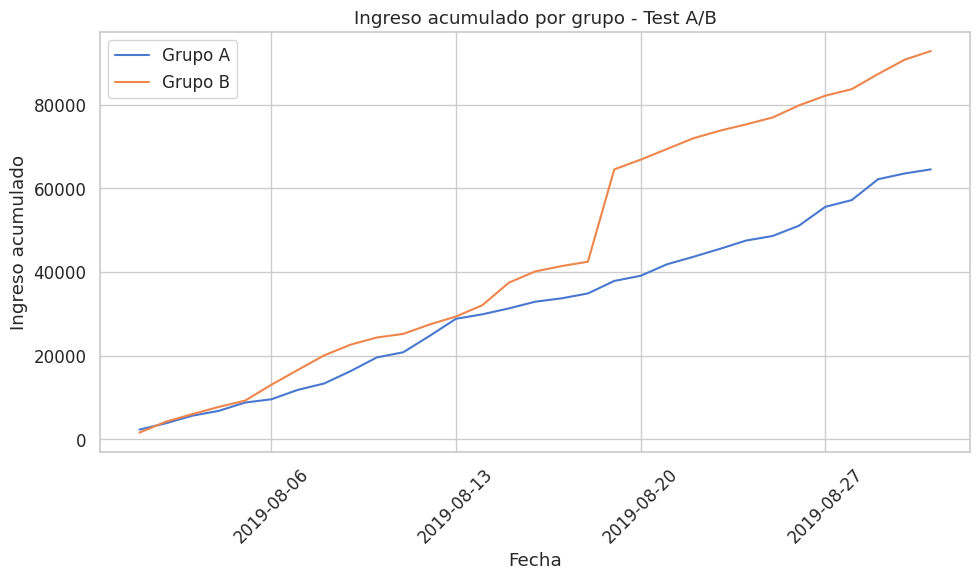

In [32]:
plt.figure(figsize=(10,6))
for group in revenue_daily['group'].unique():
    subset = revenue_daily[revenue_daily['group'] == group]
    plt.plot(subset['date'], subset['cum_revenue'], label=f'Grupo {group}')

plt.title('Ingreso acumulado por grupo - Test A/B')
plt.xlabel('Fecha')
plt.ylabel('Ingreso acumulado')
plt.legend()
plt.grid(True)

# Formato del eje X
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # mostrar 1 marca por semana
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)  # rotar etiquetas 45 grados

plt.tight_layout()
plt.show()


### Conclusiones
El Grupo B generó más ingresos acumulados que el Grupo A, con una diferencia que comenzó a ampliarse notablemente a partir del 17-20 de agosto. Esto sugiere que la variante aplicada al Grupo B tuvo un efecto positivo sostenido, aunque se requiere validación estadística para confirmar su significancia.

### Tamaño promedio de los pedidos

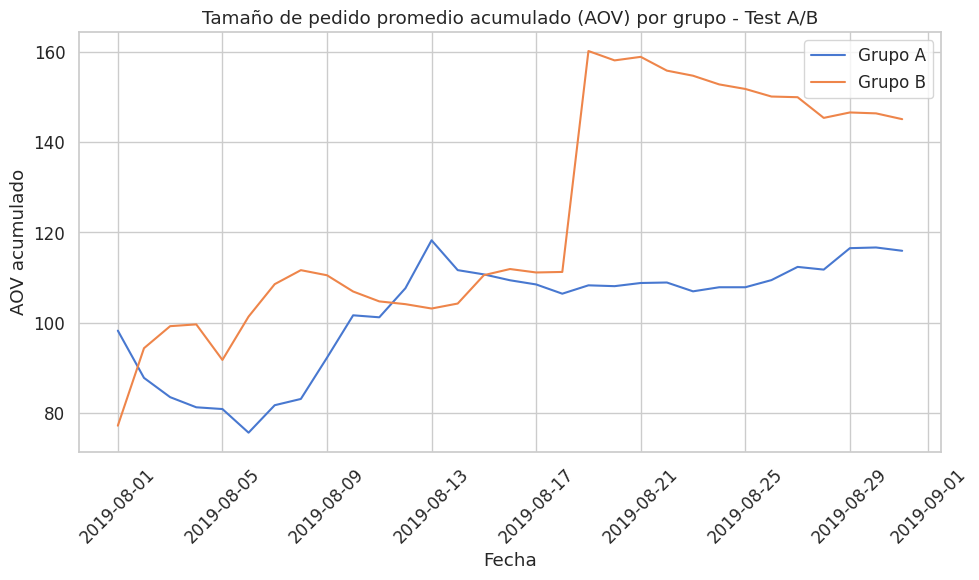

In [33]:
# Calcular ingresos y número de pedidos por fecha y grupo
orders_daily = orders.groupby(['date', 'group']).agg(
    revenue=('revenue', 'sum'),
    orders=('transactionId', 'nunique')
).reset_index()

# Calcular acumulados
orders_daily['cum_revenue'] = orders_daily.groupby('group')['revenue'].cumsum()
orders_daily['cum_orders'] = orders_daily.groupby('group')['orders'].cumsum()

# Calcular AOV acumulado
orders_daily['cum_aov'] = orders_daily['cum_revenue'] / orders_daily['cum_orders']

# Graficar
plt.figure(figsize=(10,6))
for group in orders_daily['group'].unique():
    subset = orders_daily[orders_daily['group'] == group]
    plt.plot(subset['date'], subset['cum_aov'], label=f'Grupo {group}')

plt.title('Tamaño de pedido promedio acumulado (AOV) por grupo - Test A/B')
plt.xlabel('Fecha')
plt.ylabel('AOV acumulado')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


El Grupo B tuvo un aumento abrupto en el AOV alrededor del 18 de agosto, manteniéndose por encima del Grupo A hasta el final. Esto sugiere que la variante aplicada en B pudo aumentar el valor promedio de los pedidos, aunque el salto podría estar influido por compras de alto valor puntuales.

### Diferencia Relativa

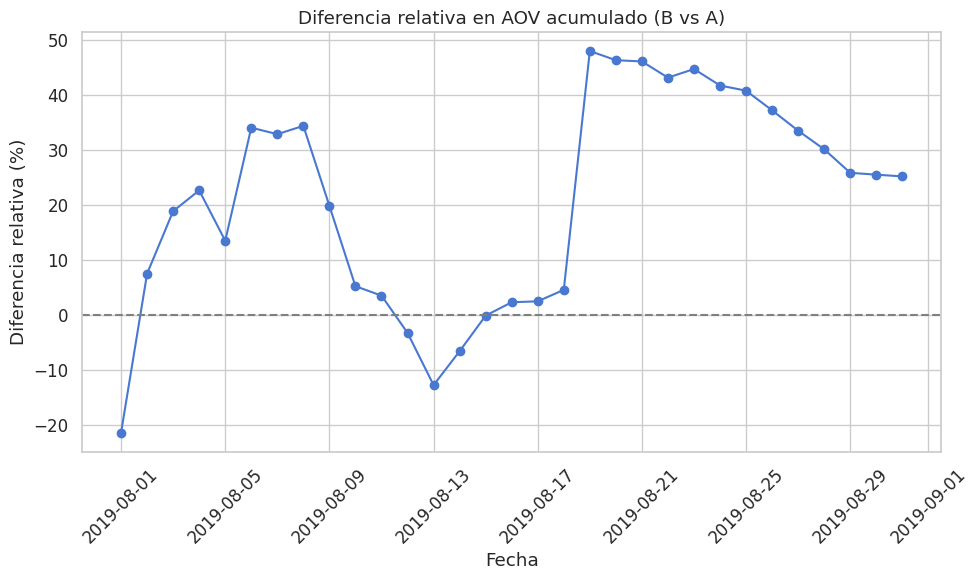

In [34]:
# Calcular ingresos y pedidos acumulados por grupo
orders_daily = orders.groupby(['date', 'group']).agg(
    revenue=('revenue', 'sum'),
    orders=('transactionId', 'nunique')
).reset_index()

orders_daily['cum_revenue'] = orders_daily.groupby('group')['revenue'].cumsum()
orders_daily['cum_orders'] = orders_daily.groupby('group')['orders'].cumsum()
orders_daily['cum_aov'] = orders_daily['cum_revenue'] / orders_daily['cum_orders']

# Separar data por grupo
aov_A = orders_daily[orders_daily['group'] == 'A'][['date', 'cum_aov']].rename(columns={'cum_aov': 'A'})
aov_B = orders_daily[orders_daily['group'] == 'B'][['date', 'cum_aov']].rename(columns={'cum_aov': 'B'})

# Unir por fecha
aov_compare = pd.merge(aov_A, aov_B, on='date')

# Calcular diferencia relativa (%)
aov_compare['diff_relative_%'] = ((aov_compare['B'] - aov_compare['A']) / aov_compare['A']) * 100

# Graficar
plt.figure(figsize=(10,6))
plt.plot(aov_compare['date'], aov_compare['diff_relative_%'], marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Diferencia relativa en AOV acumulado (B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Resumen breve:
El AOV acumulado de B supera al de A desde mediados del experimento, con un pico cercano al +48% alrededor del 18 de agosto y cerrando aún ~+25% arriba. Indica efecto positivo sostenido de la variante B en el ticket promedio.

### Tasa de Conversión (CR)

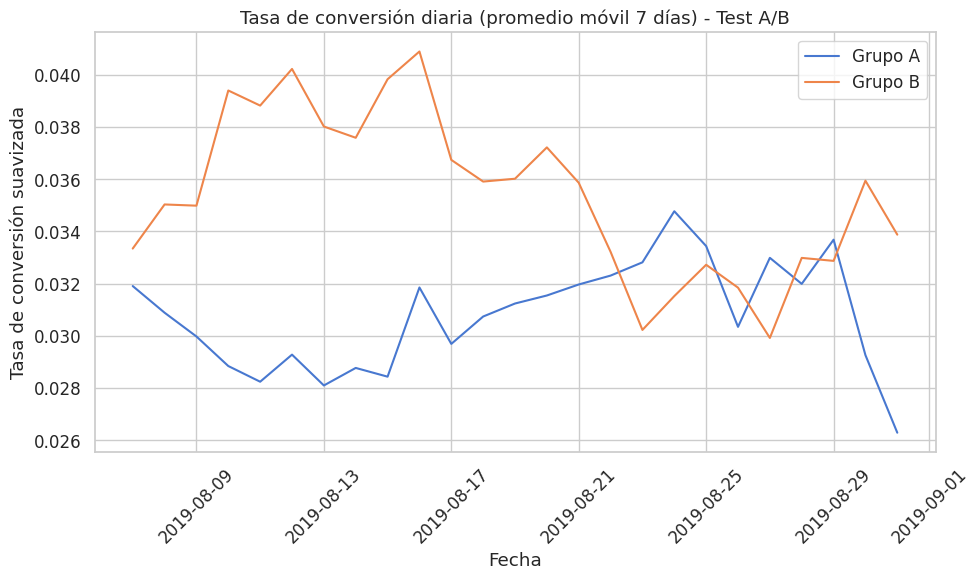

In [35]:
# Aplicar promedio móvil de 7 días para mejorar la visualización ya que diariamiente hay demasiadas fluctuaciones
cr_daily['cr_smooth'] = cr_daily.groupby('group')['conversion_rate'].transform(lambda x: x.rolling(7).mean())

# Graficar CR con suavizado
plt.figure(figsize=(10,6))
for group in cr_daily['group'].unique():
    subset = cr_daily[cr_daily['group'] == group]
    plt.plot(subset['date'], subset['cr_smooth'], label=f'Grupo {group}')

plt.title('Tasa de conversión diaria (promedio móvil 7 días) - Test A/B')
plt.xlabel('Fecha')
plt.ylabel('Tasa de conversión suavizada')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


El Grupo B mantiene consistentemente una tasa de conversión más alta que el Grupo A durante la mayor parte del experimento, lo que sugiere que la variante aplicada al Grupo B es más efectiva para generar pedidos.

### Pedidos por usuario

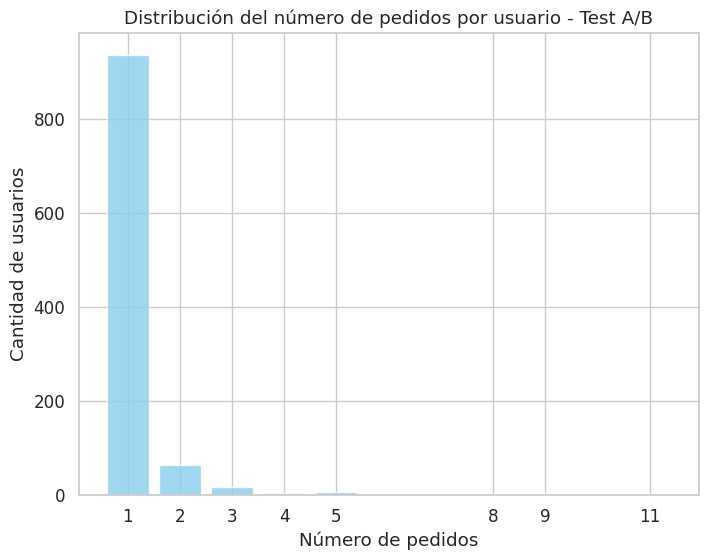

In [39]:
# Agrupar por usuario y contar pedidos
orders_per_user = orders.groupby('visitorId').size().reset_index(name='num_pedidos')

# Contar cuántos usuarios tienen 1, 2, 3... pedidos
pedidos_counts = orders_per_user['num_pedidos'].value_counts().sort_index()

# Graficar
plt.figure(figsize=(8, 6))
plt.bar(pedidos_counts.index, pedidos_counts.values, color='skyblue', alpha=0.8)
plt.title('Distribución del número de pedidos por usuario - Test A/B')
plt.xlabel('Número de pedidos')
plt.ylabel('Cantidad de usuarios')
plt.xticks(pedidos_counts.index)
plt.show()

La mayoría de los usuarios realizó solo un pedido, mientras que los casos con más de dos pedidos son muy pocos y representan outliers.

### Calcular percentiles 95 y 99

In [42]:

p95 = np.percentile(orders_per_user['num_pedidos'], 95)
p99 = np.percentile(orders_per_user['num_pedidos'], 99)

print(f"Percentil 95: {p95}")
print(f"Percentil 99: {p99}")

Percentil 95: 2.0
Percentil 99: 4.0


Un usuario con más de 4 pedidos se considera una anomalía.

### Precios de pedidos

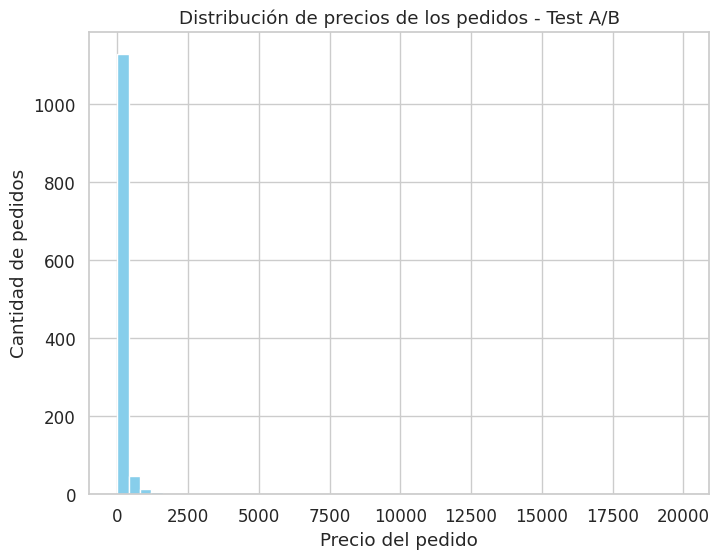

In [45]:
# Histograma de precios de pedidos
plt.figure(figsize=(8, 6))
plt.hist(orders['revenue'], bins=50, color='skyblue')
plt.title('Distribución de precios de los pedidos - Test A/B')
plt.xlabel('Precio del pedido')
plt.ylabel('Cantidad de pedidos')
plt.show()

La mayoría de los pedidos tienen precios bajos, concentrándose en un rango reducido, mientras que unos pocos pedidos presentan valores muy altos que actúan como outliers y distorsionan la escala del gráfico.


### Percentiles

In [47]:
p95_price = np.percentile(orders['revenue'], 95)
p99_price = np.percentile(orders['revenue'], 99)

print(f"Percentil 95 del precio: {p95_price}")
print(f"Percentil 99 del precio: {p99_price}")


Percentil 95 del precio: 435.54
Percentil 99 del precio: 900.9039999999999


El 95 % de los pedidos cuestan hasta 435.54 y el 99 % hasta 900.90; precios mayores son outliers.


### Significancia estadística en la conversión

In [48]:
# Crear tabla con conversión: 1 si hizo pedido, 0 si no
# Primero, usuarios únicos por grupo
users_A = set(orders[orders['group'] == 'A']['visitorId'])
users_B = set(orders[orders['group'] == 'B']['visitorId'])

# Crear lista de 1 y 0 para cada grupo
sample_A = pd.Series([1 if user in users_A else 0 for user in visits[visits['group'] == 'A']['date'].index])
sample_B = pd.Series([1 if user in users_B else 0 for user in visits[visits['group'] == 'B']['date'].index])

# Prueba Mann-Whitney U
stat, p_value = stats.mannwhitneyu(sample_A, sample_B, alternative='two-sided')

print(f'Estadístico U: {stat}')
print(f'Valor p: {p_value}')

# Interpretación
alpha = 0.05
if p_value < alpha:
    print("Diferencia estadísticamente significativa en conversión entre los grupos.")
else:
    print("No se detecta diferencia estadísticamente significativa en conversión.")

Estadístico U: 480.5
Valor p: 1.0
No se detecta diferencia estadísticamente significativa en conversión.


El cambio probado en el test A/B no tuvo un impacto medible en la conversión.

### Significancia estadística en el tamaño promedio de pedido

In [51]:
# Filtrar ingresos por grupo
revenue_A = orders[orders['group'] == 'A']['revenue']
revenue_B = orders[orders['group'] == 'B']['revenue']

# Prueba de Mann-Whitney U
stat, p_value = stats.mannwhitneyu(revenue_A, revenue_B)

print(f"Estadístico U: {stat}")
print(f"Valor p: {p_value}")

# Interpretación
if p_value < 0.05:
    print("Se detecta diferencia estadísticamente significativa en el tamaño promedio de pedido.")
else:
    print("No se detecta diferencia estadísticamente significativa en el tamaño promedio de pedido.")

Estadístico U: 175872.5
Valor p: 0.6915246773264736
No se detecta diferencia estadísticamente significativa en el tamaño promedio de pedido.


El valor p = 0.69 indica que no hay evidencia estadísticamente significativa para afirmar que el tamaño promedio de pedido difiera entre los grupos A y B.

### Significancia estadística en la conversión

In [53]:
# Filtrar por número de pedidos y precio (según percentiles)
orders_filtered = orders.groupby('visitorId').agg({
    'transactionId': 'count',
    'revenue': 'mean',
    'group': 'first'
}).reset_index()

orders_filtered.columns = ['visitorId', 'num_pedidos', 'revenue', 'group']

# Aplicar filtros: <= 2 pedidos y precio <= 900
orders_filtered = orders_filtered[
    (orders_filtered['num_pedidos'] <= 2) &
    (orders_filtered['revenue'] <= 900)
]

# Separar grupos
groupA = orders_filtered[orders_filtered['group'] == 'A']['num_pedidos']
groupB = orders_filtered[orders_filtered['group'] == 'B']['num_pedidos']

# Prueba Mann-Whitney U
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(groupA, groupB)

print(f"Estadístico U: {stat}")
print(f"Valor p: {p_value}")

if p_value < 0.05:
    print("Diferencia estadísticamente significativa en conversión.")
else:
    print("No se detecta diferencia estadísticamente significativa en conversión.")


Estadístico U: 123454.0
Valor p: 0.41257649892973514
No se detecta diferencia estadísticamente significativa en conversión.


No hay diferencia estadísticamente significativa en la conversión entre los grupos después de filtrar anomalías, ya que el valor p = 0.41 es mayor a 0.05. Esto indica que la variación observada podría deberse al azar.

### Significancia estadística en el tamaño promedio utilizando los datos filtrados.

In [56]:
print(filtered_orders['group'].value_counts())


Series([], Name: group, dtype: int64)


In [57]:
# Calcular pedidos por usuario y precio máximo de pedido
orders_per_user = orders.groupby('visitorId').agg({
    'transactionId': 'nunique',
    'revenue': 'max',
    'group': 'first'
}).reset_index()

orders_per_user.columns = ['visitorId', 'num_pedidos', 'max_revenue', 'group']

# Filtrar datos según percentiles calculados previamente
filtered_orders = orders_per_user[
    (orders_per_user['num_pedidos'] <= 2) &
    (orders_per_user['max_revenue'] <= 900)
]

print("Usuarios por grupo tras filtrado:")
print(filtered_orders['group'].value_counts())

# Extraer ingresos por grupo
groupA_revenue = filtered_orders[filtered_orders['group'] == 'A']['max_revenue']
groupB_revenue = filtered_orders[filtered_orders['group'] == 'B']['max_revenue']

# Prueba estadística Mann-Whitney U
u_stat, p_value = mannwhitneyu(groupA_revenue, groupB_revenue, alternative='two-sided')

print(f"\nEstadístico U: {u_stat}")
print(f"Valor p: {p_value}")

if p_value < 0.05:
    print("Se detecta diferencia estadísticamente significativa en el tamaño promedio de pedido.")
else:
    print("No se detecta diferencia estadísticamente significativa en el tamaño promedio de pedido.")


Usuarios por grupo tras filtrado:
B    537
A    453
Name: group, dtype: int64

Estadístico U: 123324.0
Valor p: 0.7056260307976923
No se detecta diferencia estadísticamente significativa en el tamaño promedio de pedido.


En los datos filtrados, el p-valor = 0.7056 es mucho mayor que 0.05, por lo que no se rechaza la hipótesis nula.
Esto significa que no hay evidencia estadísticamente significativa de que el tamaño promedio de pedido difiera entre los grupos A y B después del filtrado de anomalías.